# Pneunomia detection

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Képek beolvasása

ütemterv:
- Rövid helyzetjelentés emailben (sikerült-e a haladni, mi a helyzet), minden héten kedden (akkor is, ha épp nem volt rá idő vagy energia)
- Április 10-ig: kész és dokumentált feltáró adatelemzés (EDA)
- Április 19-ig: teljes, kész irodalomkutatás - adatbányászat + EDA alapok + gépi tanulás és algoritmusok melyeket használni fogsz
- Május 7-ig: elkészült gépi tanulási modellek és az eredmények értékelése
- Május 13-ig: Benyújtásra kész, általad véglegesnek ítélt dokumentáció elküldése nekem (az osztályzatnál figyelembe lesz véve az állapota)
- Május 24-ig: Az egyetemnek benyújtott dokumentáció (végső értékeléshez)
- Teljesen kész prezentáció a prezentáció előtt egy héttel legalább

In [31]:
'''!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install opencv-python'''

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import tqdm
import glob

#resnet importalasa
'''from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions'''

'from keras.applications.resnet50 import ResNet50\nfrom keras.applications.resnet50 import preprocess_input, decode_predictions'

In [32]:
# Letiltott a colab, mert elhasználtam az ingyenes keretet így most megint, nincs elég ramom. Mivel jelenleg csak az adat augmentációt szeretném megoldani elég mindössze a train normalt beolvasni.
# De ezzel azért mostmár kezdenem kell valamit.

'''train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
def resizing_all(images):
  resized_images = []
  for image in images:
    resized_image = cv2.resize(image, (256, 256))
    resized_images.append(resized_image)
  return resized_images
train_normal = resizing_all(train_normal)'''

'train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]\ndef resizing_all(images):\n  resized_images = []\n  for image in images:\n    resized_image = cv2.resize(image, (256, 256))\n    resized_images.append(resized_image)\n  return resized_images\ntrain_normal = resizing_all(train_normal)'

In [33]:
# ezzel most mukodik es keves eroforrast hasznal fel, viszont igy az eda azon része, mely a képek felbontásának meghatározására való, gyakorlatilag haszontalan lett.
def read_and_resize(path, size=(64,64)):
  img = cv2.imread(path)
  return cv2.resize(img, size)


train_normal = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
train_pneunomia = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
val_pneumonia = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
val_normal = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/NORMAL/*.jpeg"), desc = "Betoltes") ]
test_pneumonia = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
test_normal = [read_and_resize(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/NORMAL/*.jpeg"), desc = "Betoltes") ]

Betoltes: 100%|██████████| 234/234 [00:07<00:00, 31.21it/s]


In [34]:
#beolvasas
#csak akkor kell ha valtoztatni szeretnek az eda felbontas reszen
'''train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]

train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]

val_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
val_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/NORMAL/*.jpeg"), desc = "Betoltes") ]
test_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
test_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/NORMAL/*.jpeg"), desc = "Betoltes") ]'''

'train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]\n\ntrain_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]\n\nval_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]\nval_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/NORMAL/*.jpeg"), desc = "Betoltes") ]\ntest_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]\ntest_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/t

1341
3895
8
8
234
390


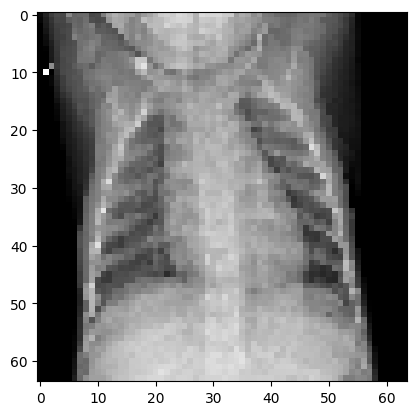

In [35]:
print(f'{len(train_normal)}')
print(f'{len(train_pneunomia)}')
print(f'{len(val_normal)}')
print(f'{len(val_pneumonia)}')
print(f'{len(test_normal)}')
print(f'{len(test_pneumonia)}')
plt.imshow(train_normal[0])


In [36]:
# beolvasas megvaltoztatva
# koncepció: a normal tüdő marad, de a bakterialis és virusosat szetvalasztjuk mindenhol(trainnél értelemszerű okokból, test-nél meg azért hogy tudjunk ellenőrzést csinálni a hatékonyságról)
import os
bacterial_lungs = []
virus_lungs = []

fajlok = glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg")

for file in tqdm.tqdm(fajlok, desc="Betöltés"):
    fajlnev = os.path.basename(file).lower()  # kisbetűs összehasonlítás miatt
    if "bacteria" in fajlnev:
        bacterial_lungs.append(read_and_resize(file))
    elif "virus" in fajlnev:
        virus_lungs.append(read_and_resize(file))

print(f"\nBacteria képek: {len(bacterial_lungs)}")
print(f"Virus képek: {len(virus_lungs)}")

Betöltés:   1%|          | 40/3895 [01:15<2:00:42,  1.88s/it]


KeyboardInterrupt: 

# Feltáró adatelemzés (Exploratory Data Analysis)

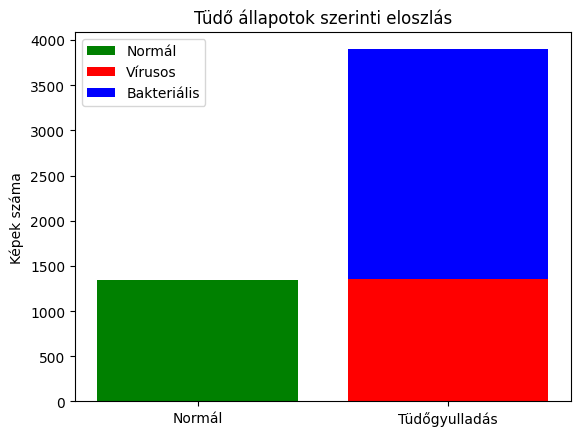

In [8]:
# class imbalance:
virus_count = len(virus_lungs)
bacteria_count = len(bacterial_lungs)
normal_count = len(train_normal)

# X-tengely címkék
x = ['Normál', 'Tüdőgyulladás']

# A stackelt oszlop részei
pneumonia_total = virus_count + bacteria_count

# Oszlopok elhelyezése
x_pos = [0, 1]

# Rajzolás
plt.bar(x_pos[0], normal_count, color='green', label='Normál')
plt.bar(x_pos[1], virus_count, color='red', label='Vírusos')
plt.bar(x_pos[1], bacteria_count, bottom=virus_count, color='blue', label='Bakteriális')

# Tengely beállítás
plt.xticks(x_pos, x)
plt.ylabel('Képek száma')
plt.title('Tüdő állapotok szerinti eloszlás')
plt.legend()
#plt.tight_layout()
plt.show()

Konklúzió: Látható, hogy fetőzött tüdőről lényegesen több kép van mint normálisról, ezáltal előfordulhat egyenlőtlenség

In [9]:
# checking the image sizes
def get_dimensions(dataset):
    dimensions = pd.DataFrame(columns=['height', 'width'])
    for i in range(0, len(dataset)):
        im = dataset[i]
        array = np.array(im)
        h,w,d = array.shape
        dimensions.loc[len(dimensions)] = [h,w]
    return dimensions

In [10]:
normal_df = get_dimensions(train_normal)

<Axes: title={'center': 'Képek felbontásának megoszlása normál tüdőknél'}, xlabel='Szélesség', ylabel='Magasság'>

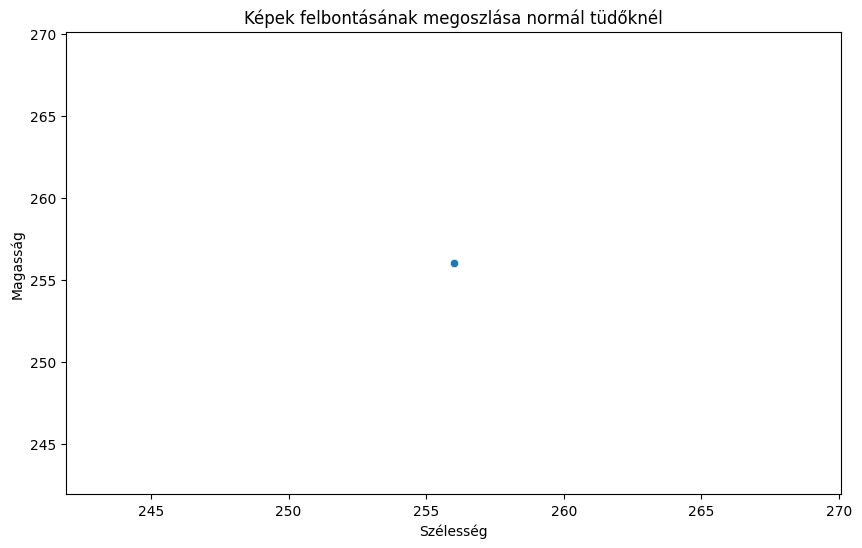

In [11]:
# plotting image sizes
plt.figure(figsize=(10,6))
plt.title('Képek felbontásának megoszlása normál tüdőknél')
plt.xlabel('Szélesség')
plt.ylabel('Magasság')
sns.scatterplot(data=normal_df, x='width', y='height')

In [12]:
pneumonia_df = get_dimensions(train_pneunomia)

<Axes: title={'center': 'Képek felbontásának megoszlása feertőzött tüdőknél'}, xlabel='Szélesség', ylabel='Magasság'>

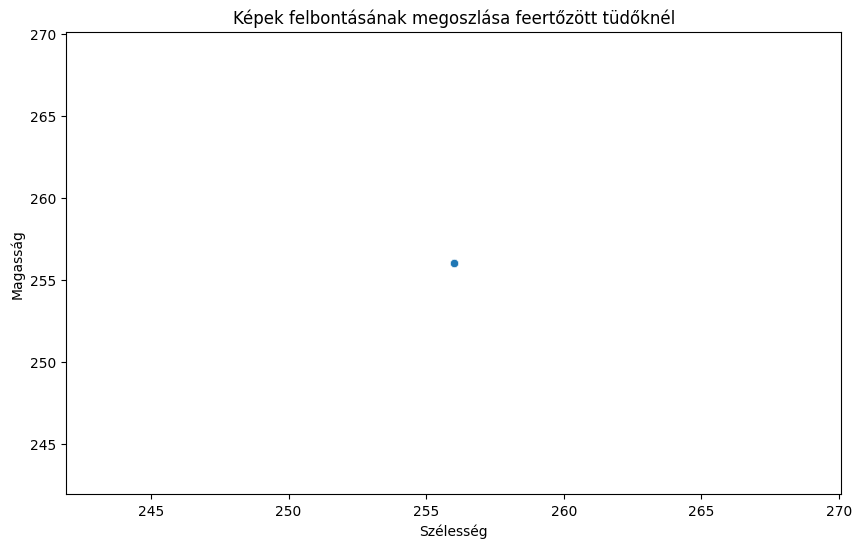

In [13]:
plt.figure(figsize=(10,6))
plt.title('Képek felbontásának megoszlása feertőzött tüdőknél')
plt.xlabel('Szélesség')
plt.ylabel('Magasság')
sns.scatterplot(data=pneumonia_df, x='width', y='height')

Konklúzió: A képek egyáltalán nem egységesek, nagyon sokféle méretben vannak jelen az adatbázisban

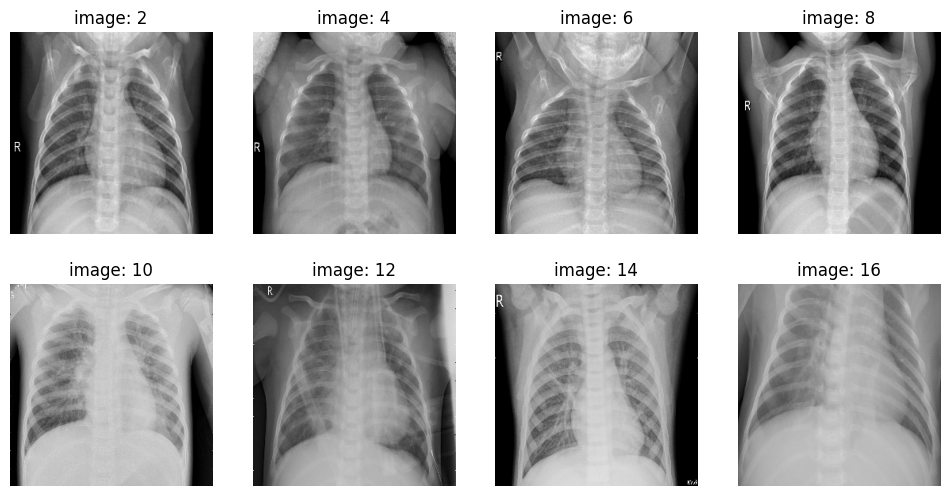

In [14]:
# Showing examples from each class
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i) #sor,oszlop,melyiknel legyen epp
    if i < 5:
        plt.imshow(train_normal[i*2])
        plt.title(f"image: {i*2}")
        plt.axis('off')
    else:
        plt.imshow(train_pneunomia[i*2])
        plt.axis('off')
        plt.title(f"image: {i*2}")


In [15]:
#resizing the images for faster calculations with keeping the aspect ratio nem is fix hogy kell
'''def resize_with_keeping_ratio(images):
    resized_images = []
    for image in images:
        # Get the original dimensions
        (h, w) = image.shape[:2]

        # Desired width
        new_width = 256

        # Calculate the aspect ratio
        aspect_ratio = h / w
        new_height = int(new_width * aspect_ratio)

        # Resize the image
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_images.append(resized_image)
    return resized_images'''
#hatekonyabb
def resize_with_keeping_ratio(images, new_width=256):
    return [cv2.resize(img, (new_width, int(new_width * img.shape[0] / img.shape[1]))) for img in images]

In [16]:
resized_normal = resize_with_keeping_ratio(train_normal)
resized_pneumonia = resize_with_keeping_ratio(train_pneunomia)

In [17]:
# Images as matrix
from tensorflow.keras.preprocessing import image
img = image.img_to_array(resized_normal[0])

In [18]:
import os
def img2np(path, list_of_filename, size=(64, 64)):
    full_mat = []  # Üres lista kezdetben

    for fn in list_of_filename:
        fp = os.path.join(path, fn)  # Helyes fájlelőérési útvonal
        current_image = image.load_img(fp, target_size=size, color_mode='grayscale')
        img_ts = image.img_to_array(current_image).ravel()  # 1D tömb

        full_mat.append(img_ts)  # Hozzáadjuk a listához

    return np.array(full_mat, dtype=np.float32)  # NumPy tömbbé alakítás

In [19]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/",list_of_files)
#Ide azért majd kéne egy kis magyarázat, jelenleg fogalmam sincs mit csinál
#pneumonia_array = img_to_np(resized_pneumonia)

In [20]:
# how does the average image looks like
def mean_img(matrix_array, title, img_size=(64, 64)):
    matrix_array = np.array(matrix_array)  # Biztosítjuk, hogy NumPy tömb
    mean = np.mean(matrix_array, axis=0)  # Átlagolás a képek dimenziója mentén
    mean = mean.reshape(img_size)  # Visszaalakítás 2D formába

    plt.imshow(mean, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Átlagos {title}')
    plt.axis('off')
    plt.show()

    return mean

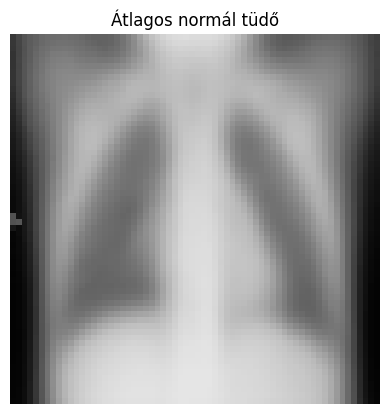

In [21]:
ANL = mean_img(normal_array,"normál tüdő") # ANL = Average Normal Lung

In [22]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/",list_of_files)

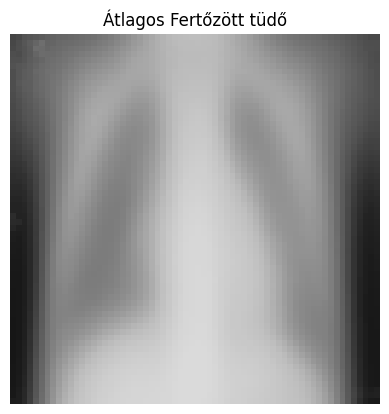

In [23]:
APL = mean_img(normal_array,"Fertőzött tüdő") # APL = Average Pneumonia Lung

Konklúzió: Látható hogy a fertőzött tüdőknél jobban elhomályosodik a mellkasi rész

Megnézzük a különbséget is a normál és a fertőzött tüdő között

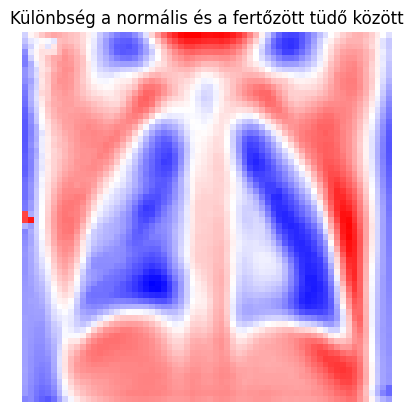

In [24]:
contrast_mean = ANL - APL
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Különbség a normális és a fertőzött tüdő között')
plt.axis('off')
plt.show()
#ez most mit jelent?

Feltáró adatelemzés lezárása, konklúziók összesítése, dokumentálás stb stb.

# Adat augmentáció elkészítése a normál halmazhoz

In [7]:
# valtozok: train_normal a normal kepek
# resized normal: aranyosan ujrameretezett kepek
# mivel a tanulo modellnek szabvany meret kell ezert a resized normalt lehet el is fogom dobni

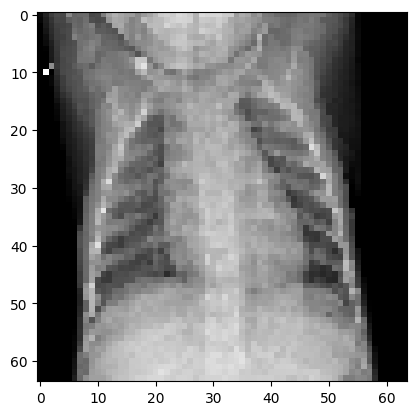

In [37]:
# kb 3x annyi kép kell mint jelenleg van. terv: a harmadat elforgatom 90 fokkal jobbra a harmadat ugyanigy balra az utolso harmadot fejjel lefele forgatom meg
#nem lehet imgaugot hasznalni az uj numpyal
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
resize_and_rescale = keras.Sequential([
    layers.Resizing(64, 64),
    layers.Rescaling(1./255) # minden pixel erteket atrak 0-255 ről 0-1 re
])
img = train_normal[0]
resized_img = resize_and_rescale(img)
plt.imshow(resized_img)
# jo tehat eddig mukodik

In [38]:
data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
  ])

def aug_rotation(images,repeat=2):
    augmented_images = []
    for idx, i in enumerate(images):
        #print(f"Kép {idx + 1}/{len(images)} augmentálása...")
        for _ in range(repeat):
          augmented_img = data_augmentation(i)# mindegyikre kettot csinalok igy meg is lesz a kepszam
          # a képek most float tipusuak nem 0-1 között
          # leosztom mindet 255-el
          augmented_images.append(augmented_img/255)
    return augmented_images

In [39]:
type(train_normal)
train_normal[0].shape
len(train_normal)

1341

In [40]:
aug_normal = aug_rotation(train_normal)
len(aug_normal)

2682

In [41]:
train_normal = train_normal + aug_normal

In [42]:
len(train_normal)

4023

Elkészült az adat augmentácó, így már 4023 képet tartalmaz a normál halmaz

# Modell kiválasztása, felépítése és betanítása

In [43]:
# lehetséges modellek amik jók lehetnek: resnet50(ezzel csináltam a betűfelismerést), sequential(ez vol kaggle-on), svm(ez volt amm órán),

Sequential model

In [44]:
train_normal[0].shape

(64, 64, 3)

In [45]:
X_train = train_normal + train_pneunomia
y_train = [0] * len(train_normal) + [1] * len(train_pneunomia)
print(len(X_train), len(y_train))

7918 7918


In [50]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
seq_model = keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(96, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(128, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
seq_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics = ['accuracy'])

In [52]:
seq_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 63, 63, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 96)          │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 7, 7, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 6, 6, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,337 (899.75 KB)

 Trainable params: 230,337 (899.75 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
seq_model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.8101 - loss: 3.1275
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9673 - loss: 0.0871
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.9786 - loss: 0.0559
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.9801 - loss: 0.0598
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 78s 171ms/step - accuracy: 0.9825 - loss: 0.0488
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.9804 - loss: 0.0542
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9831 - loss: 0.0450
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.9815 - loss: 0.0481
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy: 0.9761 - loss: 0.0524
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.9823 - loss: 0.0503


In [61]:
X_test = test_normal + test_pneumonia
y_test = [0] * len(test_normal) + [1] * len(test_pneumonia)
seq_loss, seq_acc = seq_model.evaluate(np.array(X_test), np.array(y_test))
print(f"A teszthalmazon elért pontosság: {seq_acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6014 - loss: 1.7835
A teszthalmazon elért pontosság: 0.7740384340286255


In [58]:
predicitons = seq_model.predict(np.array(X_test))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


array([[3.2271114e-01],
       [6.0125820e-02],
       [8.5093421e-01],
       [9.7961646e-01],
       [1.5153128e-01],
       [5.8052701e-01],
       [9.9339908e-01],
       [9.0173912e-01],
       [8.2906497e-01],
       [5.1032666e-02],
       [5.0499856e-01],
       [9.9329543e-01],
       [9.7721225e-01],
       [9.9687463e-01],
       [9.9704808e-01],
       [1.8035826e-01],
       [5.3928775e-01],
       [4.5696151e-01],
       [7.2066313e-01],
       [3.0736094e-02],
       [7.1535051e-01],
       [3.1443870e-01],
       [9.9879575e-01],
       [8.2910094e-07],
       [6.7332530e-01],
       [7.8594923e-01],
       [7.8804106e-01],
       [9.8215705e-01],
       [4.0472460e-06],
       [2.5313651e-02],
       [4.3128887e-01],
       [9.1962236e-01],
       [4.4663452e-02],
       [4.0311050e-01],
       [9.6980894e-01],
       [9.9995703e-01],
       [9.8995143e-01],
       [5.1692313e-01],
       [7.5670731e-01],
       [3.7319009e-05],
       [9.9484754e-01],
       [7.408121